## Runtime Duration of UAT data
Analytics on Runtime data of the UAT reports.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# prep the environment
data_dir = Path.cwd() / "data"
data_file = data_dir / "uat_data.pkl"

%matplotlib inline


In [13]:
# load the UAT runtime data
uat_df = pd.read_pickle(data_file)
print(f"Found {len(uat_df)} records.")
time_df = uat_df.set_index('StartTime')


Found 1888 records.


### Overview


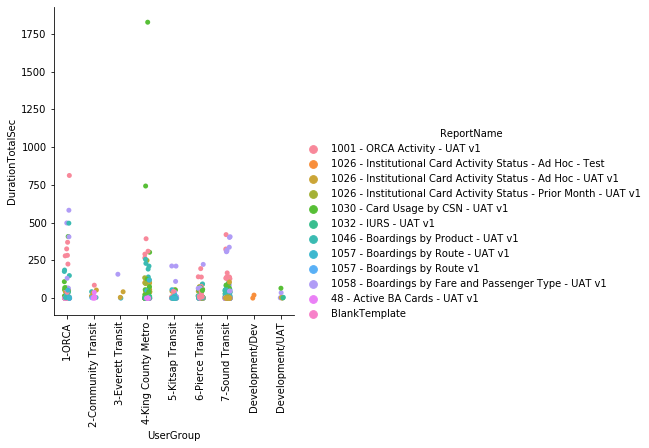

In [14]:
sns.catplot(x='UserGroup', y='DurationTotalSec', hue='ReportName', data=time_df)
plt.xticks(rotation=90)
plt.show()


### Runtime Split


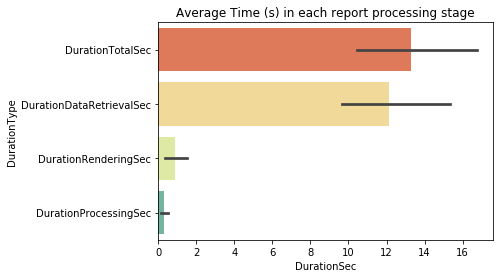

In [16]:
time_duration_df = time_df.melt(['User', 'ResultStatus', 'ReportName'], var_name='DurationType', value_name='DurationSec', value_vars=['DurationTotalSec', 'DurationDataRetrievalSec', 'DurationRenderingSec', 'DurationProcessingSec'])
sns.barplot(x='DurationSec', y='DurationType', data=time_duration_df, palette='Spectral')
plt.title('Average Time (s) in each report processing stage')
plt.show()